In [1]:
from __future__ import division, print_function, absolute_import

from skimage import color, io
from scipy.misc import imresize
import numpy as np
from sklearn.model_selection import train_test_split
import os
from glob import glob

import tensorflow as tf

from collections import namedtuple


import pickle

import tflearn
from tflearn.data_utils import shuffle, to_categorical
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation
from tflearn.metrics import Accuracy

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd

<h1>Input Data and Format</h1>
- Read data from folders. 
- Label pictures. 
- Normalize & Reshape for training. 
- Create and Save Batches.

In [2]:
##################################
### Import picture files 
###################################

alex_files_path = os.path.join("./alex/", '*.*')
cat_files_path = os.path.join("./cat/", '*.*')

alex_files = sorted(glob(alex_files_path))
cat_files = sorted(glob(cat_files_path))
n_files = len(alex_files) + len(cat_files)
print(str(n_files) + " Total Files")
print(str(len(alex_files)) + " Photos of Alex")
print(str(len(cat_files)) + " Photos of Cat")

346 Total Files
173 Photos of Alex
173 Photos of Cat


In [3]:
#Test an Image at Desired Reshape Size

size_image = 224

allX = np.zeros((n_files, size_image, size_image, 3), dtype='float64')
ally = np.zeros(n_files)
count = 0

In [4]:
img = io.imread("./cat/IMG_8030.png")[:,:,:3]
print("Original Shape: " + str(img.shape))
new_img = imresize(img, (size_image, size_image, 3))
print("New Shape: " + str(new_img.shape))
allX[count] = np.array(new_img)

Original Shape: (3024, 4032, 3)
New Shape: (224, 224, 3)


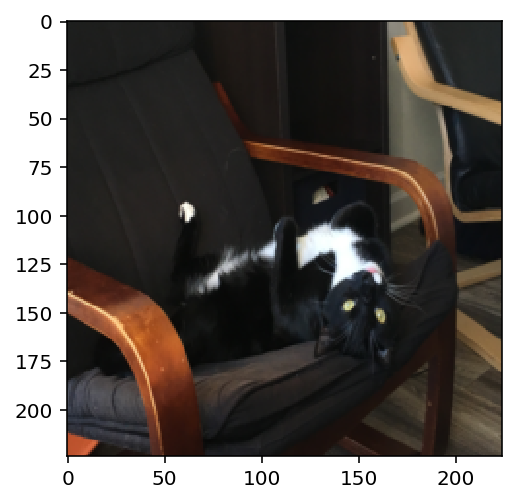

In [5]:
#Plot Test Image
plt.imshow(new_img)
plt.show()

In [6]:
#Reshape All Files to Desired Size
for f in alex_files:
    try:
        img = io.imread(f)[:,:,:3]
        new_img = imresize(img, (size_image, size_image, 3))
        allX[count] = np.array(new_img)
        ally[count] = 0
        count += 1
    except:
        print("Error on "+f)

for f in cat_files:
    try:
        img = io.imread(f)[:,:,:3]
        new_img = imresize(img, (size_image, size_image, 3))
        allX[count] = np.array(new_img)
        ally[count] = 1
        count += 1
    except:
        print("Error on "+f)

In [7]:
#Function for Normalizing Pixels
def normalize(x):
    norm = np.array((x - np.min(x)) / (np.max(x) - np.min(x)))
    return norm

In [8]:
#Normalize and Encode Targets
y = to_categorical(ally, 2)
X = normalize(allX)

In [9]:
#Split Data into Train/Test
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
#Create Batches and Save Them
n_batches = 5
valid_features = []
valid_labels = []
batch_size = round(len(X_train)/n_batches)
start = 0
for batch_i in range(1, n_batches + 1):
    end = batch_size*batch_i
    features = X_train[start:end+1]
    labels = Y_train[start:end+1]
    validation_count = int(len(X_train) * 0.1)
    filename = './data/preprocess_batch_' + str(batch_i) + '.p'
    
    pickle.dump((features, labels), open(filename, 'wb'))

    # Use a portion of training batch for validation
    valid_features.extend(features[-validation_count:])
    valid_labels.extend(labels[-validation_count:])
    
    start = batch_size*batch_i

# Save Portion of Training Set as Validation
pickle.dump((valid_features, valid_labels), open('./data/preprocess_validation.p', 'wb'))

# Save Test Data Sets - Not in Batches
pickle.dump((X_test, Y_test), open('./data/preprocess_testing.p', 'wb'))

<h1>Define Neural Network</h1>
- Network consists of: 
    - 2 Convolutional Layers with Maxpooling
    - 2 Fully Connected Layers with dropout between. 
- Parameters are defined below. 
- conv_net() is defined to build all layers

In [76]:
#Define Some Parameters for CNN
conv1_num_outputs = 32
conv2_num_outputs = 64
conv3_num_outputs = 128
conv4_num_outputs = 256
conv5_num_outputs = 128
conv1_ksize = (3,3)
conv1_strides = (1,1)
conv2_ksize = (4,4)
conv2_strides = (1,1)
conv3_ksize = (4,4)
conv3_strides = (1,1)
pool_ksize = (2,2)
pool_strides = (2,2)
fc1_size = 256
fc2_size = 56
logit_classes = 2

In [87]:
def conv_net():
    tf.reset_default_graph()
    
    with tf.name_scope('inputs'):
        x = tf.placeholder(tf.float32, [None, size_image, size_image, 3], name="x")
        print("Input: " + str(x.get_shape()))
    
    with tf.name_scope('targets'):
        y = tf.placeholder(tf.float32, [None, 2], name="y")
        
    #with tf.name_scope('keep_prob'):
    keep_prob = tf.placeholder(tf.float32, name="keep_prob")
        
    with tf.name_scope('conv_1'):
        shape = x.get_shape().as_list()
        weight = tf.Variable(tf.truncated_normal([conv1_ksize[0], conv1_ksize[1], shape[3], conv1_num_outputs], mean=0.0, stddev=0.1))
        bias = tf.Variable(tf.zeros(conv1_num_outputs))
        conv1 = tf.nn.conv2d(x, filter=weight, strides=[1, conv1_strides[0], conv1_strides[1], 1], padding='VALID', name='convolution_1')
        conv1 = tf.nn.bias_add(conv1, bias)
        conv1 = tf.nn.relu(conv1)
        conv1 = tf.nn.max_pool(conv1, ksize=[1, pool_ksize[0], pool_ksize[1], 1], strides=[1, pool_strides[0], pool_strides[1], 1]
                              , padding='SAME', name='maxpool_1')
        conv1 = tf.nn.dropout(conv1, keep_prob)
        
        #Print Shape
        print("Conv1: " + str(conv1.get_shape().as_list()))
        
    
    with tf.name_scope('conv_2'):
        shape = conv1.get_shape().as_list()
        weight = tf.Variable(tf.truncated_normal([conv2_ksize[0], conv2_ksize[1], shape[3], conv2_num_outputs], mean=0.0, stddev=0.1))
        bias = tf.Variable(tf.zeros(conv2_num_outputs))
        conv2 = tf.nn.conv2d(conv1, filter=weight, strides=[1, conv2_strides[0], conv2_strides[1], 1], padding='VALID', name='convolution_2')
        conv2 = tf.nn.bias_add(conv2, bias)
        conv2 = tf.nn.relu(conv2)
        conv2 = tf.nn.max_pool(conv2, ksize=[1, pool_ksize[0], pool_ksize[1], 1], strides=[1, pool_strides[0], pool_strides[1], 1]
                              , padding='SAME', name='maxpool_1')
        conv2 = tf.nn.dropout(conv2, keep_prob)
        
        #Print Shape
        print("Conv2: " + str(conv2.get_shape()))
        
    with tf.name_scope('conv_3'):
        shape = conv2.get_shape().as_list()
        weight = tf.Variable(tf.truncated_normal([conv3_ksize[0], conv3_ksize[1], shape[3], conv3_num_outputs], mean=0.0, stddev=0.1))
        bias = tf.Variable(tf.zeros(conv3_num_outputs))
        conv3 = tf.nn.conv2d(conv2, filter=weight, strides=[1, conv3_strides[0], conv3_strides[1], 1], padding='VALID', name='convolution_3')
        conv3 = tf.nn.bias_add(conv3, bias)
        conv3 = tf.nn.relu(conv3)
#         conv3 = tf.nn.max_pool(conv3, ksize=[1, pool_ksize[0], pool_ksize[1], 1], strides=[1, pool_strides[0], pool_strides[1], 1]
#                               , padding='SAME', name='maxpool_1')
#         conv3 = tf.nn.dropout(conv3, keep_prob)
        
        #Print Shape
        print("Conv3: " + str(conv3.get_shape()))        
        
        
    with tf.name_scope('conv_4'):
        shape = conv3.get_shape().as_list()
        weight = tf.Variable(tf.truncated_normal([conv3_ksize[0], conv3_ksize[1], shape[3], conv4_num_outputs], mean=0.0, stddev=0.1))
        bias = tf.Variable(tf.zeros(conv4_num_outputs))
        conv4 = tf.nn.conv2d(conv3, filter=weight, strides=[1, conv3_strides[0], conv3_strides[1], 1], padding='VALID', name='convolution_4')
        conv4 = tf.nn.bias_add(conv4, bias)
        conv4 = tf.nn.relu(conv4)
        print("Conv4: " + str(conv4.get_shape())) 
        
    with tf.name_scope('conv_5'):
        shape = conv4.get_shape().as_list()
        weight = tf.Variable(tf.truncated_normal([conv3_ksize[0], conv3_ksize[1], shape[3], conv5_num_outputs], mean=0.0, stddev=0.1))
        bias = tf.Variable(tf.zeros(conv5_num_outputs))
        conv5 = tf.nn.conv2d(conv4, filter=weight, strides=[1, conv3_strides[0], conv3_strides[1], 1], padding='VALID', name='convolution_5')
        conv5 = tf.nn.bias_add(conv5, bias)
        conv5 = tf.nn.relu(conv5)
        conv5 = tf.nn.max_pool(conv5, ksize=[1, pool_ksize[0], pool_ksize[1], 1], strides=[1, pool_strides[0], pool_strides[1], 1]
                              , padding='SAME', name='maxpool_1')
        conv5 = tf.nn.dropout(conv5, keep_prob)        
        print("Conv5: " + str(conv5.get_shape())) 
        
    with tf.name_scope('flatten'):
        tensor_shape = conv5.get_shape().as_list()
        flattened_shape = np.array(tensor_shape[1:]).prod()
        flat = tf.reshape(conv5, [tf.shape(conv5)[0], flattened_shape], name='flat')
    
        #Print Shape
        print("Flat: " + str(flat.get_shape()))
    
    with tf.name_scope('fully_connected'):
        #First Fully Connected Layer
        flattened_shape = np.array(flat.get_shape().as_list()[1:]).prod()
        weights = tf.Variable(tf.truncated_normal([flattened_shape, fc1_size], stddev=0.1))
        bias = tf.Variable(tf.zeros([fc1_size]))
        fc = tf.nn.relu(tf.add(tf.matmul(flat, weights), bias), name='fc1')   
        
        #Print Shape
        print("FC 1: "+ str(fc.get_shape()))
        
        #Apply Dropout
        #fc = tf.nn.dropout(fc, keep_prob)
        
        #Second Fully Connected Layer
        flattened_shape = np.array(fc.get_shape().as_list()[1:]).prod()
        weights = tf.Variable(tf.truncated_normal([flattened_shape, fc2_size], stddev=0.1))
        bias = tf.Variable(tf.zeros([fc2_size]))
        fc = tf.nn.relu(tf.add(tf.matmul(fc, weights), bias), name='fc1')  
        
        #Print Shape
        print("FC 2: " + str(fc.get_shape()))
        
    with tf.name_scope('output'):
        flattened_shape = np.array(fc.get_shape().as_list()[1:]).prod()
        # Define trainable variables.
        weights = tf.Variable(tf.truncated_normal([flattened_shape, logit_classes], stddev=0.04))
        bias = tf.Variable(tf.zeros([logit_classes]))

        # Output layer.    
        preds = tf.add(tf.matmul(fc, weights), bias, name='logits')
        
        #Print Shape
        print("Output: " + str(preds.get_shape()))
    
    with tf.name_scope('cost'):
        # Loss and Optimizer
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=preds, labels=y)) 
        optimizer = tf.train.AdamOptimizer().minimize(cost)
    
    correct_pred = tf.equal(tf.argmax(preds, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
    
    
    # Export the nodes 
    export_nodes = ['x', 'y','keep_prob', 'cost', 'preds', 'optimizer', 'accuracy']
    Graph = namedtuple('Graph', export_nodes)
    local_dict = locals()
    graph = Graph(*[local_dict[each] for each in export_nodes])
    
    return graph

<h1>Train the Net</h1>
- print_stats() function defined for printing training statistics
- loop through all batches of training data to train Net

In [88]:
#print_stats function for Training
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    loss_score = session.run(cost, feed_dict={model.x: feature_batch, model.y: label_batch, model.keep_prob: 1.0})
    accu_score = session.run(accuracy, feed_dict={model.x: valid_features, model.y: valid_labels, model.keep_prob: 1.0})
    print('Loss: {:>10.4f}  Validation Accuracy: {:.6f}'.format(loss_score, accu_score))

In [131]:
# Training Parameters
epochs = 40
keep_probability = 0.8

In [132]:
#Get Validation Data for Training
valid_features, valid_labels = pickle.load(open('./data/preprocess_validation.p', mode='rb'))

In [133]:
model = conv_net()

Input: (?, 224, 224, 3)
Conv1: [None, 111, 111, 32]
Conv2: (?, 54, 54, 64)
Conv3: (?, 51, 51, 128)
Conv4: (?, 48, 48, 256)
Conv5: (?, 23, 23, 128)
Flat: (?, 67712)
FC 1: (?, 256)
FC 2: (?, 56)
Output: (?, 2)


In [134]:
save_model_path = './alex_cat'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    print('Session Initialized')
    # Training cycle
    for epoch in range(epochs):
        #Loop over every batch 
        for batch_i in range(1, n_batches + 1):
            features, labels = pickle.load(open('./data/preprocess_batch_'+str(batch_i)+'.p', mode='rb'))
            print('Loaded Data for Epoch {:>2}, Batch {}'.format(epoch+1, batch_i), end='')
            feed = {'keep_prob:0': keep_probability, 
                    'inputs/x:0': features, 
                    'targets/y:0': labels}
            sess.run(model.optimizer, feed_dict=feed)
            print(' Epoch {:>2}, Photo Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess,  features, labels, model.cost, model.accuracy)
    # Output to TensorBoard
    writer = tf.summary.FileWriter("./logs")
    writer.add_graph(sess.graph)
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Session Initialized
Loaded Data for Epoch  1, Batch 1 Epoch  1, Photo Batch 1:  Loss:   119.8636  Validation Accuracy: 0.466667
Loaded Data for Epoch  1, Batch 2 Epoch  1, Photo Batch 2:  Loss:    27.0477  Validation Accuracy: 0.466667
Loaded Data for Epoch  1, Batch 3 Epoch  1, Photo Batch 3:  Loss:     1.3464  Validation Accuracy: 0.503704
Loaded Data for Epoch  1, Batch 4 Epoch  1, Photo Batch 4:  Loss:     3.1128  Validation Accuracy: 0.533333
Loaded Data for Epoch  1, Batch 5 Epoch  1, Photo Batch 5:  Loss:     2.7996  Validation Accuracy: 0.533333
Loaded Data for Epoch  2, Batch 1 Epoch  2, Photo Batch 1:  Loss:     0.9922  Validation Accuracy: 0.525926
Loaded Data for Epoch  2, Batch 2 Epoch  2, Photo Batch 2:  Loss:     1.3339  Validation Accuracy: 0.474074
Loaded Data for Epoch  2, Batch 3 Epoch  2, Photo Batch 3:  Loss:     1.3880  Validation Accuracy: 0.466667
Loaded Data for Epoch  2, Batch 4 Epoch  2, Photo Batch 4:  Loss:     1.0531  Validation Accuracy: 0.474

In [135]:
n_samples = 70
top_n_predictions = 2

In [136]:
X_test, Y_test = pickle.load(open('./data/preprocess_testing.p', mode='rb'))

In [137]:
from sklearn.preprocessing import LabelBinarizer
def display_image_predictions(features, labels, predictions, rows, width, height):
    n_classes = 2
    label_names = ['alex', 'cat']
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=rows, ncols=2, figsize=(width,height))
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 2
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])

INFO:tensorflow:Restoring parameters from ./alex_cat
TopKV2(values=array([[  9.20254886e-01,   7.97451213e-02],
       [  7.11773217e-01,   2.88226783e-01],
       [  7.98111379e-01,   2.01888636e-01],
       [  6.97088361e-01,   3.02911669e-01],
       [  9.41070676e-01,   5.89292757e-02],
       [  9.81672466e-01,   1.83275174e-02],
       [  8.20359588e-01,   1.79640427e-01],
       [  9.90063250e-01,   9.93671827e-03],
       [  9.80369627e-01,   1.96303669e-02],
       [  9.95591819e-01,   4.40817699e-03],
       [  7.59210110e-01,   2.40789905e-01],
       [  9.50392187e-01,   4.96078618e-02],
       [  9.99644995e-01,   3.54967051e-04],
       [  9.92466509e-01,   7.53342733e-03],
       [  8.84841800e-01,   1.15158193e-01],
       [  8.70657086e-01,   1.29342914e-01],
       [  9.98995483e-01,   1.00449380e-03],
       [  9.99966741e-01,   3.32415730e-05],
       [  9.89228010e-01,   1.07719637e-02],
       [  9.99994397e-01,   5.61344359e-06],
       [  7.06393719e-01,   2.936

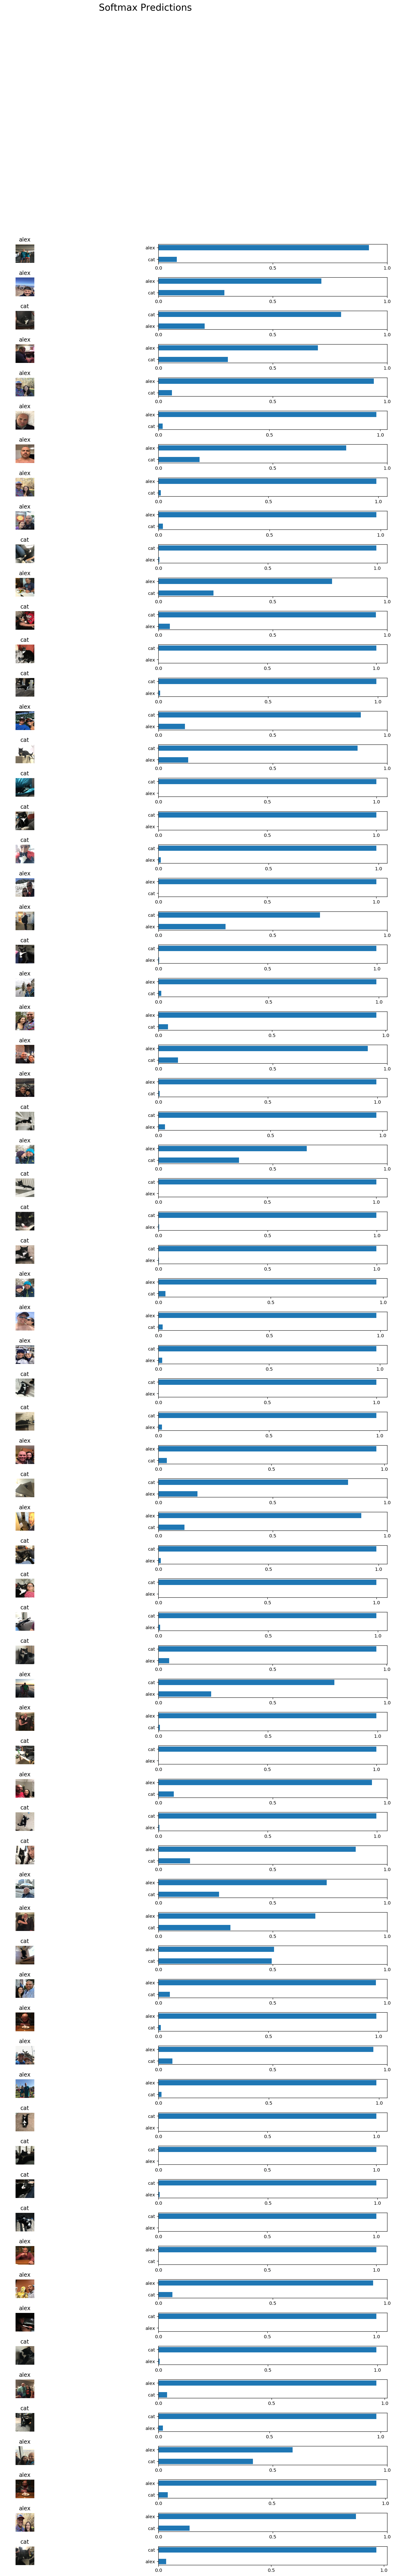

In [138]:
loaded_graph = tf.Graph()

import random 

with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('inputs/x:0')
        loaded_y = loaded_graph.get_tensor_by_name('targets/y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('output/logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(X_test, Y_test)), n_samples)))
        predictions = sess.run(
            tf.nn.softmax(loaded_logits), 
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        print(random_test_predictions)
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions, 70, 15, 70)
        
        

In [139]:
labels = np.vstack(random_test_labels)

In [140]:
#Create Data Frame of Results on Test Set
data = {'alex_pred':predictions[:,0], 'cat_pred':predictions[:,1]
            , 'alex':labels[:,0], 'cat':labels[:,1]}
data = pd.DataFrame(data)

In [141]:
def classify(row):
    if row['cat_pred'] > row['alex_pred']:
        return 1
    else:
        return 0

def correct(row):
    if row['pred'] == row['cat']:
        return 1
    else:
        return 0

In [142]:
data['pred'] = data.apply(lambda row: classify(row), axis=1)
data['correct'] = data.apply(lambda row: correct(row), axis=1)

In [143]:
sum(data['correct'])/70

0.90000000000000002

<h1>What happens when an image is Alex AND Cat?</h1>

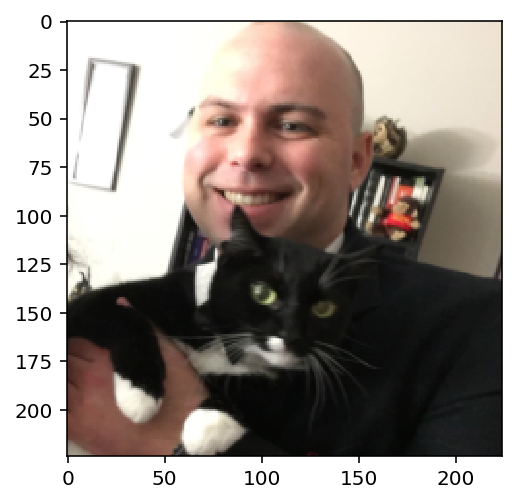

In [144]:
#See what happens when predicting picture of Alex & Cat
size_image = 224
newinput = np.zeros((1, size_image, size_image, 3), dtype='float64')
count=0

img = io.imread("/Users/alexlentz/Desktop/alex_cat.png")[:,:,:3]
new_img = imresize(img, (size_image, size_image, 3))
newinput[count] = np.array(new_img)
newinput = normalize(newinput)
plt.imshow(new_img)
plt.show()

In [145]:
loaded_graph = tf.Graph()

import random 
n_samples = 1 

with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('inputs/x:0')
        loaded_y = loaded_graph.get_tensor_by_name('targets/y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('output/logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(X_test, Y_test)), n_samples)))
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        predictions = sess.run(
            tf.nn.softmax(loaded_logits), 
            feed_dict={loaded_x: newinput, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: newinput, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        print(predictions)

INFO:tensorflow:Restoring parameters from ./alex_cat
[[ 0.06321807  0.93678194]]


<h1>Explore output of tf_cnnvis library </h1>

https://github.com/InFoCusp/tf_cnnvis

In [146]:
from tf_cnnvis import *

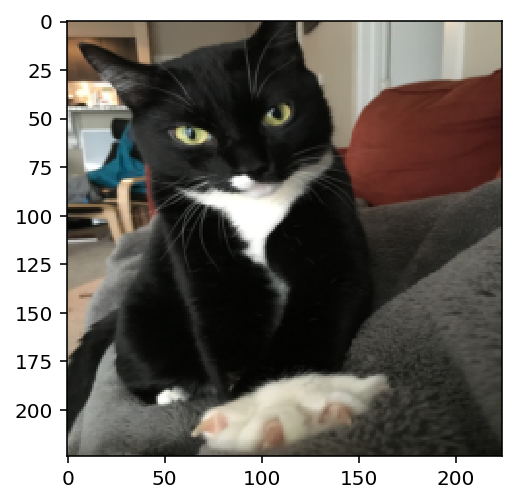

In [152]:
size_image = 224
catinput = np.zeros((1, size_image, size_image, 3), dtype='float64')
alexinput = np.zeros((1, size_image, size_image, 3), dtype='float64')
count=0

#img = io.imread("/Users/alexlentz/Desktop/alex_cat.png")[:,:,:3]
cat_img = io.imread("./cat/IMG_1588.png")[:,:,:3]
new_cat = imresize(cat_img, (size_image, size_image, 3))
catinput[count] = np.array(new_cat)
catinput = normalize(catinput)
plt.imshow(new_cat)
plt.show()

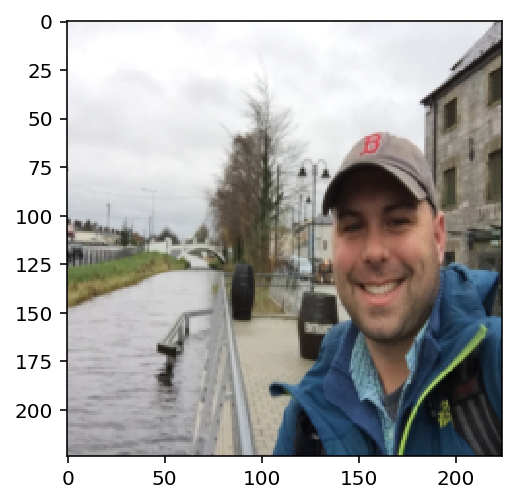

In [153]:
alex_img = io.imread("./alex/IMG_1698.png")[:,:,:3]
new_alex = imresize(alex_img, (size_image, size_image, 3))
alexinput[count] = np.array(new_alex)
alexinput = normalize(alexinput)
plt.imshow(new_alex)
plt.show()

In [154]:
# deconv visualization
#layers = ["r", "p", "c"]
layers = ["p"]
total_time = 0


deconv_visualization(graph_or_path = loaded_graph, value_feed_dict = { loaded_x: catinput, loaded_keep_prob: 0.8}, 
                                      layers=layers, path_logdir="./logs/cat", 
                                      path_outdir="./logs/cat/pics")

deconv_visualization(graph_or_path = loaded_graph, value_feed_dict = { loaded_x: alexinput, loaded_keep_prob: 0.8}, 
                                      layers=layers, path_logdir="./logs/alex", 
                                      path_outdir="./logs/alex/pics")

INFO:tensorflow:Restoring parameters from model/tmp-model
Reconstruction Completed for conv_1/maxpool_1 layer. Time taken = 2.906946 s
Reconstruction Completed for conv_2/maxpool_1 layer. Time taken = 6.796417 s
Reconstruction Completed for conv_5/maxpool_1 layer. Time taken = 22.658305 s
INFO:tensorflow:Restoring parameters from model/tmp-model
Reconstruction Completed for conv_1/maxpool_1 layer. Time taken = 3.146998 s
Reconstruction Completed for conv_2/maxpool_1 layer. Time taken = 6.290367 s
Reconstruction Completed for conv_5/maxpool_1 layer. Time taken = 24.025857 s


True

In [157]:
#Try Google Deep Dream
deepdream_visualization(graph_or_path = loaded_graph, value_feed_dict = { loaded_x: X_test, loaded_keep_prob: 1.0}
                        , layer='fully_connected/fc1_1', classes=[0,1], 
                        #input_tensor='x:0', 
                        path_logdir="./logs", 
                                      path_outdir="./logs/pics")

INFO:tensorflow:Restoring parameters from model/tmp-model


/Users/alexlentz/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


0, 1 -> featuremap completed.
Reconstruction Completed for fully_connected/fc1_1 layer. Time taken = 142.497665 s


True

<h1>Compare Net to Other Classifiers</h1>

Is it worth the effort to create a net? Compare results to: 
- Gradient Boosted Trees
- Logistic Regression
- Support Vector Machine

In [158]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [160]:
y = to_categorical(ally, 2)
X = normalize(allX)

In [161]:
Xreshaped = X.reshape((n_files, -1))

In [162]:
X_train, X_test, Y_train, Y_test = train_test_split(Xreshaped, ally, test_size=0.2, random_state=42)

In [163]:
clf = GradientBoostingClassifier()

In [164]:
clf.fit(X_train, Y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [165]:
clf.score(X_test, Y_test)

0.84285714285714286

In [171]:
data['GBT_pred'] = clf.predict(X_test)
data['GBT_proba_0'] = clf.predict_proba(X_test)[:,0]
data['GBT_proba_1'] = clf.predict_proba(X_test)[:,1]

In [172]:
lgr = LogisticRegression()
lgr.fit(X_train, Y_train)
lgr.score(X_test, Y_test)

0.77142857142857146

In [173]:
data['LR_pred'] = lgr.predict(X_test)
data['LR_proba_0'] = lgr.predict_proba(X_test)[:,0]
data['LR_proba_1'] = lgr.predict_proba(X_test)[:,1]

In [176]:
svc = SVC( probability=True)
svc.fit(X_train, Y_train)
svc.score(X_test, Y_test)

0.68571428571428572

In [177]:
data['SV_pred'] = svc.predict(X_test)
data['SV_proba_0'] = svc.predict_proba(X_test)[:,0]
data['SV_proba_1'] = svc.predict_proba(X_test)[:,1]

In [178]:
data.to_csv("./results.csv")